In [1]:
# RL MODEL: POLICY GRADIENT

In [2]:
import tensorflow as tf


import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import time

In [3]:
env = gym.make('CartPole-v0')
env.seed(1)


[1]

In [4]:
print(env.observation_space)
print(env.action_space)

help(gym.envs.classic_control.CartPoleEnv)

Box(4,)
Discrete(2)
Help on class CartPoleEnv in module gym.envs.classic_control.cartpole:

class CartPoleEnv(gym.core.Env)
 |  Description:
 |      A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.
 |  
 |  Source:
 |      This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson
 |  
 |  Observation: 
 |      Type: Box(4)
 |      Num     Observation                 Min         Max
 |      0       Cart Position             -4.8            4.8
 |      1       Cart Velocity             -Inf            Inf
 |      2       Pole Angle                 -24 deg        24 deg
 |      3       Pole Velocity At Tip      -Inf            Inf
 |      
 |  Actions:
 |      Type: Discrete(2)
 |      Num     Action
 |      0       Push cart to the left
 |      1       Push cart to the 

In [5]:
def create_cartpole_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=2, activation=None)
    ])
    return model


In [6]:
def choose_action(model, observation):
    
    observation = observation.reshape([1, -1])
    '''TODO: feed the observations through the model to predict the log probabilities of each possible action.'''
    logits = model.predict(observation)

    # pass the log probabilities through a softmax to compute true probabilities
    prob_weights = tf.nn.softmax(logits).numpy()

    '''TODO: randomly sample from the prob_weights to pick an action.
    Hint: carefully consider the dimensionality of the input probabilities (vector) and the output action (scalar)'''
    action = np.random.choice(2, size=1, p=prob_weights.flatten())[0]

    return action

In [7]:
class Memory:
    def __init__(self): 
        self.clear()

    def clear(self): 
        self.observations = []
        self.actions = []
        self.rewards = []

    def add_to_memory(self, new_observation, new_action, new_reward): 
        self.observations.append(new_observation)
        self.actions.append(new_action)
        self.rewards.append(new_reward)

memory = Memory()

In [17]:
def normalize(x):
    x -= np.mean(x)
    x /= np.std(x)
    return x

def discount_rewards(rewards, gamma=0.95):
    discounted_rewards = np.zeros_like(rewards)
    R = 0
    
    for i, rew in enumerate(reversed(rewards)):
        R = R * gamma + rewards[len(rewards)-i-1]
        discounted_rewards[len(rewards)-i-1] = R
    
    return normalize(discounted_rewards)
        
        

In [18]:
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(lr)

In [19]:
def compute_loss(logits, actions, rewards):
    neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
    loss = tf.reduce_mean(neg_logprob * rewards)
    return loss

In [20]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
    with tf.GradientTape() as tape:
        observation = tf.convert_to_tensor(observations, dtype=tf.float32)
        logits = model(observation)
        loss = compute_loss(logits, actions, discounted_rewards)
        
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

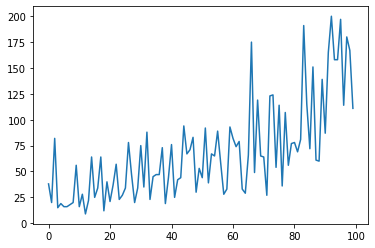

In [24]:
import matplotlib.pyplot as plt

cartpole_model = create_cartpole_model()
total_rewards = []
for i in range(100):
    observation = env.reset()
    if i+1 % 1000 == 0:
        print("step: {}".format(i))
    while True:
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        
        memory.add_to_memory(observation, action, reward)
        
        if done:
            total_reward = sum(memory.rewards)
            total_rewards.append(total_reward)
            
            train_step(cartpole_model, optimizer,
                      observations=np.vstack(memory.observations),
                      actions=np.array(memory.actions),
                      discounted_rewards=discount_rewards(memory.rewards))
            
            memory.clear()
            break
            
        observation = next_observation
        
plt.plot(total_rewards)

In [25]:
#HOW IT WORKS
import time
import gym
env = gym.make('CartPole-v0')
obs = env.reset()

for _ in range(100):
    env.render()
    time.sleep(0.1)
#     action = choose_action(cartpole_model, obs)
    action = env.action_space.
    obs, reward, done, _ = env.step(action) # take a random action
    if done:
        break
env.close()